# Preprocessing

In [44]:
# To import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from gudhi import bottleneck_distance
from scipy.io import savemat
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

# To define FPS function
def farthest_point_sampling(distance_matrix, num_total_points, num_required_sample):
    initial_point = np.random.randint(num_total_points)
    sampled_points, distance_from_sample = [initial_point], distance_matrix[initial_point].copy()
    
    for _ in range(num_required_sample - 1):
        farthest_point = np.argmax(distance_from_sample)
        sampled_points.append(farthest_point)
        another_distance_from_sample = distance_matrix[farthest_point]
        for point in range(num_total_points):
            if distance_from_sample[point] > another_distance_from_sample[point]:
                distance_from_sample[point] = another_distance_from_sample[point]
    
    return sampled_points

In [2]:
total_diagrams, total_shapes = [], []

# To read .vert files
directory_path = r'C:\Users\leo&grace\w\kaist\TDA\nonrigid3d'

vert_files = [f for f in os.listdir(directory_path) if f.endswith('.vert')]
vert_files.sort()
num_files = len(vert_files)

for vert_file in vert_files:
    vert_file_path = os.path.join(directory_path, vert_file)

    coordinates, length = [], 0
    with open(vert_file_path, 'r') as file:
        for line in file:
            coordinates.append(list(map(float, line.split())))
            length += 1
    
# To compute euclidean distance matrix
    euclidean_distance_matrix = np.zeros((length, length))
    
    for i in range(length):
        for j in range(length):
            if j < i:
                euclidean_distance_matrix[i][j] = euclidean_distance_matrix[j][i]
            else:
                euclidean_distance_matrix[i][j] = np.linalg.norm(np.subtract(coordinates[i], coordinates[j]))

# To subsample 200 points via FPS & to reduce the distance matrix
    our_sample = farthest_point_sampling(euclidean_distance_matrix, length, 200)
    reduced_distance_matrix = []
    
    for _ in our_sample:
        reduced_distance_matrix.append([euclidean_distance_matrix[_][j] for j in our_sample])

# Compute the Vietoris-Rips persistence diagrams in dimensions 0, 1, and 2
    diagram = ripser(np.array(reduced_distance_matrix), maxdim=2, distance_matrix=True)['dgms']
    total_diagrams.append(diagram)
    
# To create "shape"
    file_name = vert_file.split(".")[0]
    shape = {'name': file_name, 'dm': reduced_distance_matrix}
    total_shapes.append(shape)

# To save results
    save_directory = r'C:\Users\leo&grace\w\kaist\TDA\processed_euclidean'
    
    mat_file_path = os.path.join(save_directory, f"pre_euclidean_{file_name}.mat")
    savemat(mat_file_path, shape)

In [40]:
# group information
group_label = ['cat', 'centaur', 'david', 'dog', 'gorilla', 'horse', 'lioness', 'michael', 'seahorse', 'shark', 'victoria', 'wolf']
groups, checkpoint = {}, 0
for obj in group_label:
    groups[obj] = []
    for idx in range(checkpoint, num_files):
        if total_shapes[idx]['name'].startswith(obj):
            groups[obj].append(idx)
        else:
            checkpoint = idx
            break

# Matrix: dDiam

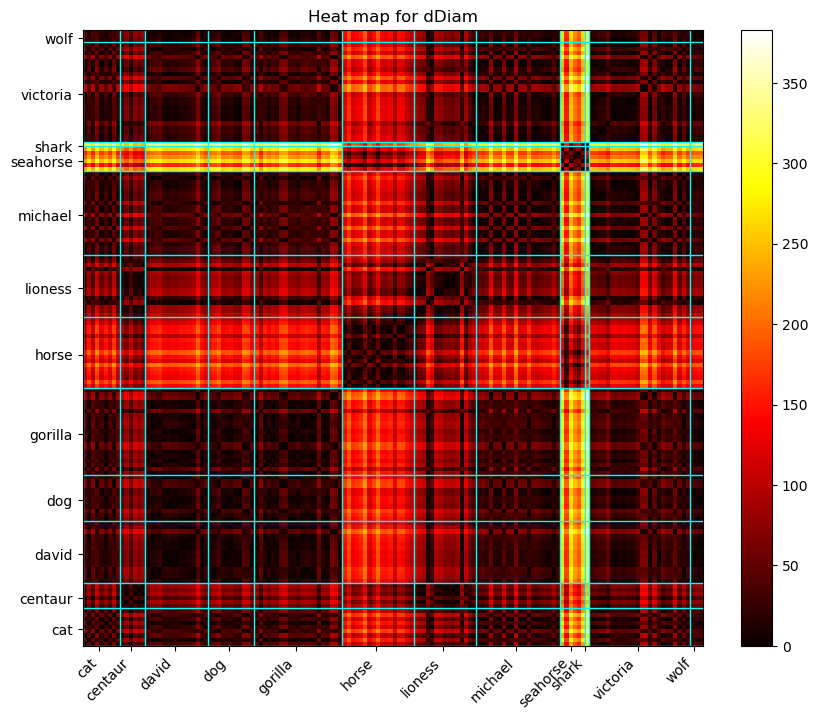

In [37]:
# To compute dDiam matrix
dDiam_matrix = np.zeros((num_files, num_files))

for i in range(num_files):
    for j in range(num_files):
        if j < i:
            dDiam_matrix[i][j] = dDiam_matrix[j][i]
        else:
            dDiam_matrix[i][j] = abs(np.max(total_shapes[i]['dm']) - np.max(total_shapes[j]['dm']))

# To save the result
np.savetxt(r'C:\Users\leo&grace\w\kaist\TDA\dDiam_euclidean.csv', dDiam_matrix, delimiter=',')

# To draw a image: heat map
fig, ax = plt.subplots(figsize=(10, 8))
heatmap = ax.pcolormesh(dDiam_matrix, cmap='hot')

ax.set_xticks([np.median(groups[group]) for group in group_label])
ax.set_yticks([np.median(groups[group]) for group in group_label])

ax.set_xticklabels(group_label, rotation=45, ha='right')
ax.set_yticklabels(group_label)

for group_name, group_indices in groups.items():
    ax.axhline(min(group_indices), color='cyan', linewidth=1)
    ax.axvline(min(group_indices), color='cyan', linewidth=1)

cbar = plt.colorbar(heatmap)

plt.savefig('heatmap_euclidean_dDiam.png')
plt.title("Heat map for dDiam")
plt.show()

# Matrix based on euclidean distance matrix and Bottleneck distance

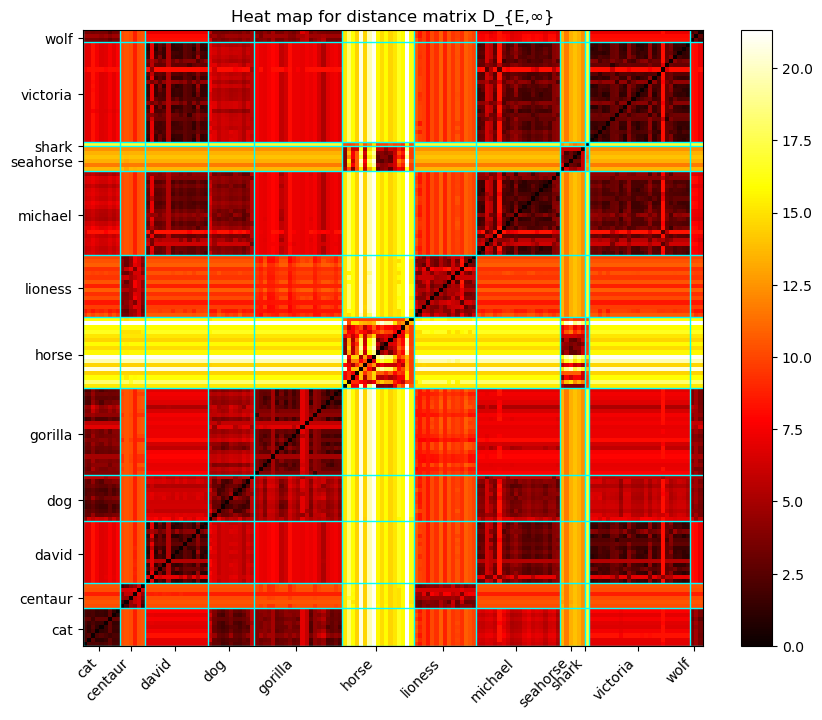

In [47]:
# To compute the bottleneck distance matrix
bottleneck_distance_matrix = np.zeros((num_files, num_files))

for i in range(num_files):
    for j in range(num_files):
        if j < i:
            bottleneck_distance_matrix[i][j] = bottleneck_distance_matrix[j][i]
        elif j == i:
            bottleneck_distance_matrix[i][j] = 0
        else:
            bottleneck_distance_matrix[i][j] = max([bottleneck_distance(total_diagrams[i][_], total_diagrams[j][_]) for _ in range(3)])

# To save the result
np.savetxt(r'C:\Users\leo&grace\w\kaist\TDA\euclidean_bottleneck.csv', bottleneck_distance_matrix, delimiter=',')

# To draw a image: heat map
fig, ax = plt.subplots(figsize=(10, 8))
heatmap = ax.pcolormesh(bottleneck_distance_matrix, cmap='hot')

ax.set_xticks([np.median(groups[group]) for group in group_label])
ax.set_yticks([np.median(groups[group]) for group in group_label])

ax.set_xticklabels(group_label, rotation=45, ha='right')
ax.set_yticklabels(group_label)

for group_name, group_indices in groups.items():
    ax.axhline(min(group_indices), color='cyan', linewidth=1)
    ax.axvline(min(group_indices), color='cyan', linewidth=1)

cbar = plt.colorbar(heatmap)

plt.savefig('heatmap_euclidean_bottleneck.png')
plt.title("Heat map for distance matrix D_{E,∞}")
plt.show()

# Clustering based on D_{E,∞}

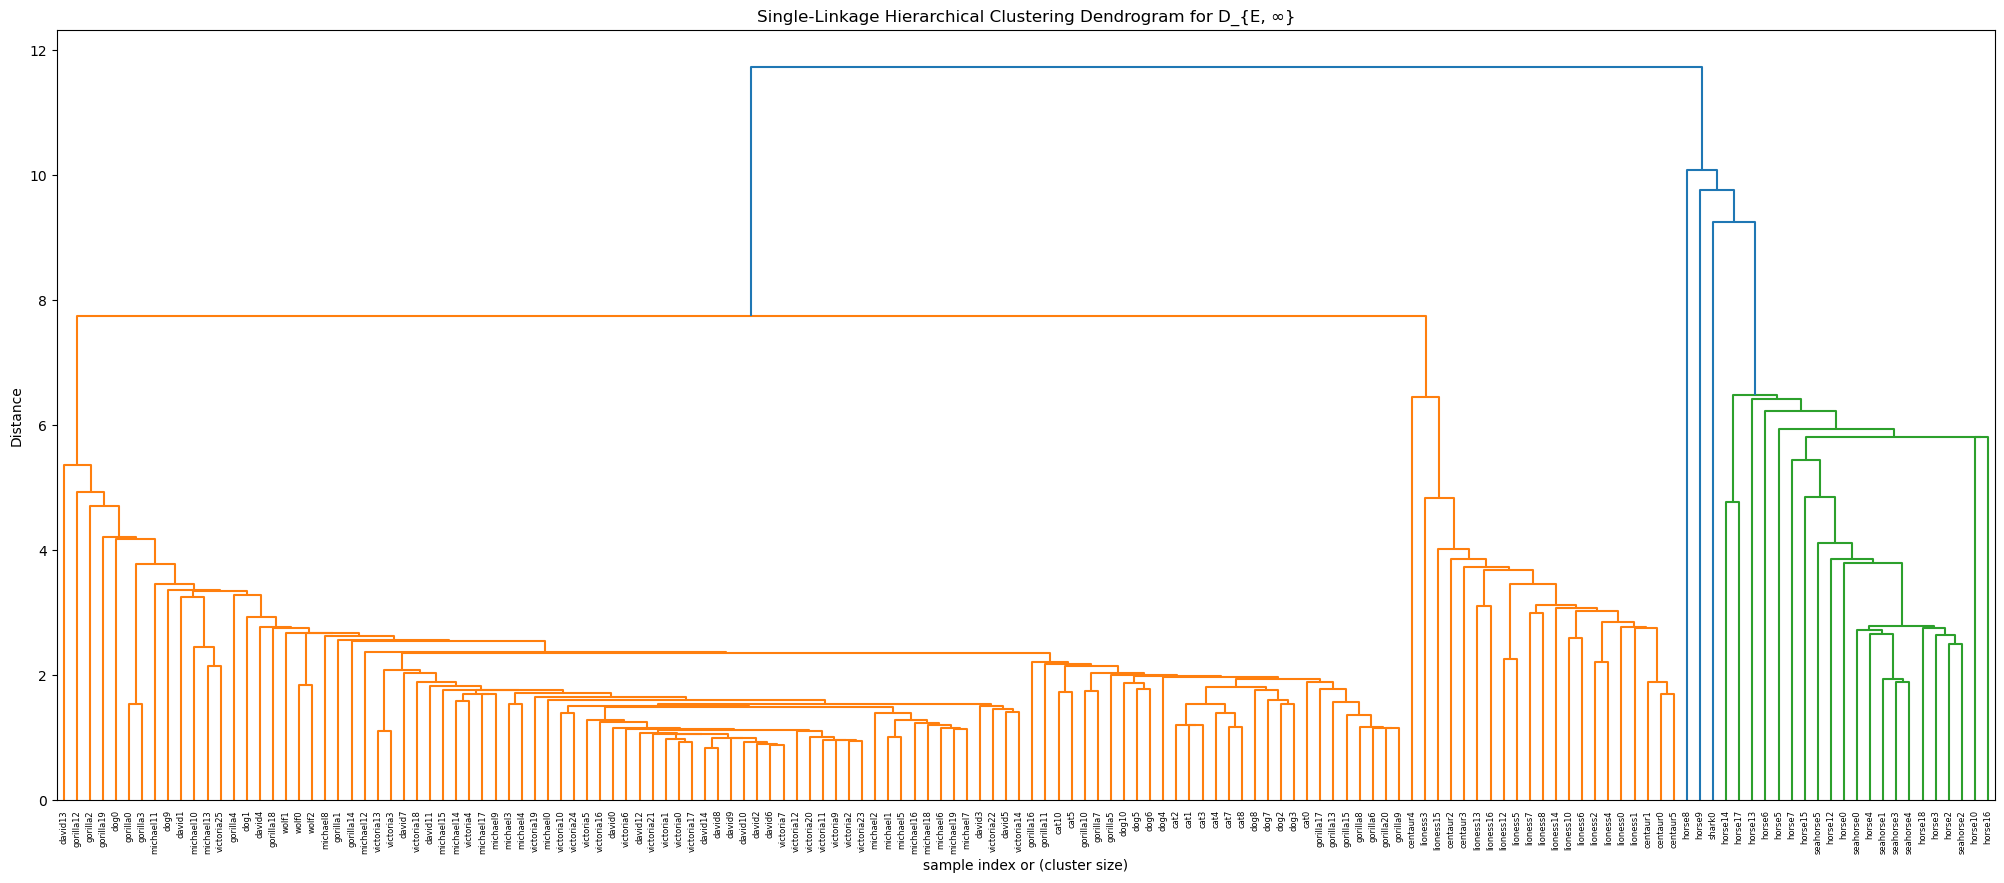

In [56]:
linkage_matrix_bottleneck = linkage(squareform(bottleneck_distance_matrix))

plt.figure(figsize=(25, 10))
plt.title('Single-Linkage Hierarchical Clustering Dendrogram for D_{E, ∞}')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('Distance')

dendrogram(linkage_matrix_bottleneck, leaf_label_func=lambda x: total_shapes[x]['name'], leaf_rotation=90., leaf_font_size=6.)

plt.savefig('Dendrogram_euclidean_bottleneck')
plt.show()